## Feature 조합 실루엣 상위 4개 

In [ ]:
import numpy as np
import operator
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples

data_set_lgbm = pd.read_pickle("../../data/base_dataset_predict_proba.pkl")
print(data_set_lgbm)
def get_cluster_list(target_data_set: pd.DataFrame, features: list[list[str]], target_label: str):
    
    kmeans_label = "kmeans_label"
    silhouette_df = pd.DataFrame(columns=["mean", "std", "combine"])
    
    for idx_feature in range(len(features)):
    
        data_set = target_data_set[features[idx_feature]]
        len_data_set = len(data_set)

        # 2. 기준이 되는 임의의 두 데이터 생성
        n_class = 4
        centroids = np.linspace(start=0, stop=1, num=n_class * 3).reshape(-1, 3)
        class_count = len(centroids)

        # 3. 데이터를 순회하며 더 가까운 데이터를 찾아 클래스 분류
        classes = [ [idx, centroid] for idx, centroid in enumerate(centroids) ]
        classifications = np.full(shape=(len(data_set),), fill_value=-1, dtype=int)

        while True:
            temp_classifications = np.full(shape=(len(data_set),), fill_value=-1, dtype=int)
            centroid_eucliean_distances = np.zeros((len_data_set, class_count)) # 각 클래스 기준 데이터들과의 유클리디언 거리 배열
            for (idx_data, data) in data_set.iterrows():
                data = np.array(data)
                diffs = abs(centroids - data) # 클래스 기준 데이터와의 값 - 절댓값
                centroid_eucliean_distances[idx_data] = np.sum(diffs, axis=1) ** 0.5 # 유클리디언 거리 계산
            for idx_data in range(len_data_set):
                (min_clazz, _) = min(enumerate(centroid_eucliean_distances[idx_data]), key=operator.itemgetter(1))
                temp_classifications[idx_data] = min_clazz    
            if np.all(classifications == temp_classifications): # 5. 과정을 반복하며 더이상의 분류가 일어나지 않을 때 종료
                break
            classifications = temp_classifications
            # 4. 클래스 별 데이터 클러스터의 중심을 구해 클래스 데이터 갱신
            classify_data_idx_set = [ [] for _ in range(class_count) ]
            for (idx, clazz) in enumerate(iterable=classifications):
                classify_data_idx_set[clazz].append(idx)
            means = [ np.mean(data_set.iloc[idx_set], axis=0) for idx_set in classify_data_idx_set ]
            centroids = np.stack(means)
            
        kmeans = pd.Series(classifications, name=kmeans_label)
        data_set = pd.concat([data_set, kmeans], axis="columns")
        
        # 전체 실루엣 계산
        data_set = pd.concat([data_set, target_data_set[target_label]], axis="columns")
        data_set["real_silhouette"] = silhouette_samples(X=data_set[features[idx_feature]], labels=data_set[target_label])
        data_set["pred_silhouette"] = silhouette_samples(X=data_set[features[idx_feature]], labels=data_set[kmeans_label])
        real_silhouette_means = data_set.groupby(target_label)["real_silhouette"].mean()
        pred_silhouette_means = data_set.groupby(kmeans_label)["pred_silhouette"].mean()
        
        df_mean_std = pd.DataFrame([[pred_silhouette_means.mean(), pred_silhouette_means.std(), idx_feature]], columns=["mean", "std", "combine"])
        silhouette_df = pd.concat([silhouette_df,df_mean_std], axis=0).reset_index(drop=True)
        
        # 군집별 실루엣 계산
        real_silhouette_score = silhouette_score(X=data_set[features[idx_feature]], labels=data_set[target_label])
        pred_silhouette_score = silhouette_score(X=data_set[features[idx_feature]], labels=data_set[kmeans_label])
        
    sort = silhouette_df.sort_values(["mean", "std"], ascending=[False, True])
    print("<<<<<<<<<<<<<<<<< 상위 4개 피쳐 리스트 >>>>>>>>>>>>>>>>>>")
    for index in sort["combine"][:4]:
        print(f"{index} : {features[index]}")

candidate_features = [
    "Customer_Age",
    "Dependent_count",
    "Education_Level",
    # "Marital_Status_Uneducated",
    # "Marital_Status_Single",
    # "Marital_Status_Divorced",
    "Income_Category",
    "Card_Category",
    "Months_on_book",
    "Total_Relationship_Count",
    "Credit_Limit",
    "Total_Revolving_Bal"
]

combine_features = [ 
    [candidate_features[i], candidate_features[j], "Attrition_probabilities"] 
    for i in range(len(candidate_features))
    for j in range(i+1, len(candidate_features))
]

print(combine_features)

get_cluster_list(target_data_set=data_set_lgbm, features=combine_features, target_label="Attrition_Flag")

## 시각화 및 데이터 프레임 클러스터링

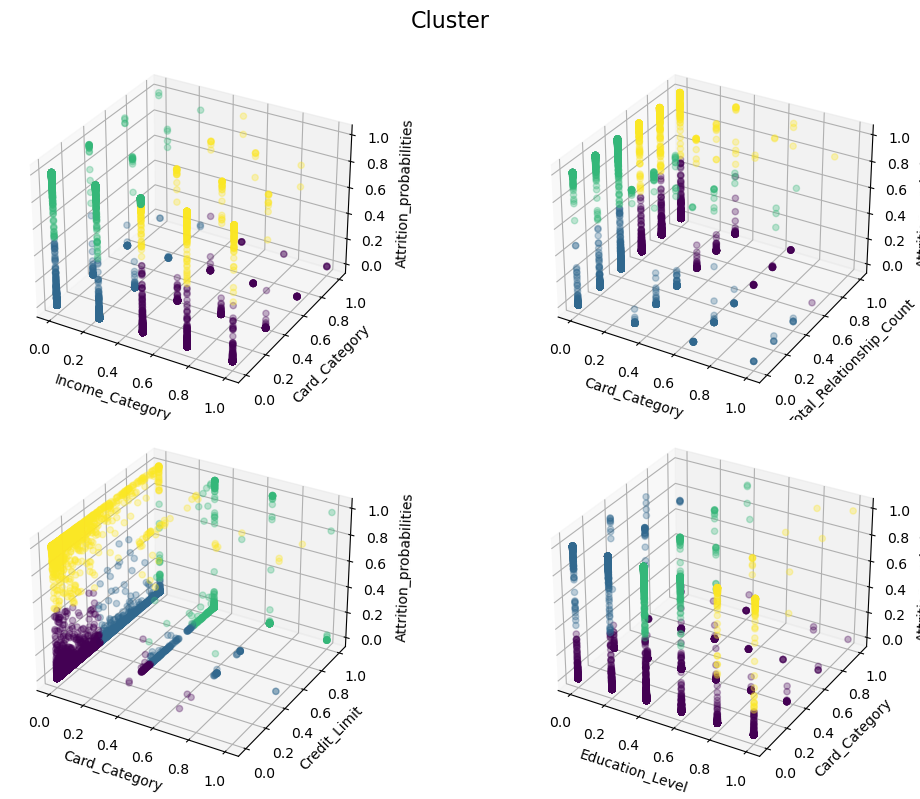

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import os

data_set_lgbm = pd.read_pickle("../../data/base_dataset_predict_proba.pkl")

def get_cluster_list(target_data_set: pd.DataFrame, features: list[list[str]]):

    fig = plt.figure(figsize=(12, 8))
    kmeans_label = "kmeans_label"
    
    for idx_feature in range(len(features)):
    
        data_set = target_data_set[features[idx_feature]]
        len_data_set = len(data_set)

        # 2. 기준이 되는 임의의 두 데이터 생성
        n_class = 4
        centroids = np.linspace(start=0, stop=1, num=n_class * 3).reshape(-1, 3)
        class_count = len(centroids)

        # 3. 데이터를 순회하며 더 가까운 데이터를 찾아 클래스 분류
        classes = [ [idx, centroid] for idx, centroid in enumerate(centroids) ]
        classifications = np.full(shape=(len(data_set),), fill_value=-1, dtype=int)

        while True:
            temp_classifications = np.full(shape=(len(data_set),), fill_value=-1, dtype=int)
            centroid_eucliean_distances = np.zeros((len_data_set, class_count)) # 각 클래스 기준 데이터들과의 유클리디언 거리 배열
            for (idx_data, data) in data_set.iterrows():
                data = np.array(data)
                diffs = abs(centroids - data) # 클래스 기준 데이터와의 값 - 절댓값
                centroid_eucliean_distances[idx_data] = np.sum(diffs, axis=1) ** 0.5 # 유클리디언 거리 계산
            for idx_data in range(len_data_set):
                (min_clazz, _) = min(enumerate(centroid_eucliean_distances[idx_data]), key=operator.itemgetter(1))
                temp_classifications[idx_data] = min_clazz    
            if np.all(classifications == temp_classifications): # 5. 과정을 반복하며 더이상의 분류가 일어나지 않을 때 종료
                break
            classifications = temp_classifications
            # 4. 클래스 별 데이터 클러스터의 중심을 구해 클래스 데이터 갱신
            classify_data_idx_set = [ [] for _ in range(class_count) ]
            for (idx, clazz) in enumerate(iterable=classifications):
                classify_data_idx_set[clazz].append(idx)
            means = [ np.mean(data_set.iloc[idx_set], axis=0) for idx_set in classify_data_idx_set ]
            centroids = np.stack(means)
            
        kmeans = pd.Series(classifications, name=kmeans_label)
        data_set = pd.concat([data_set, kmeans], axis="columns")
        
        for i in range(n_class):
            cluster_data_set = target_data_set[classifications == i]
            file_postfix = f"X{round(centroids[i][0], 2)}_Y{round(centroids[i][1], 2)}_Z{round(centroids[i][2], 2)}"
            dir = f"cluster{idx_feature}"
            try:
                os.mkdir(dir)
            except:
                pass
            cluster_data_set.to_pickle(f"{dir}/cluster_data_set-{file_postfix}.pkl")

        x = data_set.iloc[:, 0]
        y = data_set.iloc[:, 1]
        z = data_set.iloc[:, 2]
        
        ax = fig.add_subplot(200 + int(len(features)/2*10) + idx_feature+1, projection='3d')
        ax.scatter(x, y, z, c=classifications, marker='o', alpha=0.3)
        ax.set_xlabel(features[idx_feature][0])
        ax.set_ylabel(features[idx_feature][1])
        ax.set_zlabel(features[idx_feature][2])
        
    plt.suptitle('Cluster', fontsize=16)
    fig.tight_layout()
    plt.show()
    
test_feature_list = [
    ['Income_Category', 'Card_Category', 'Attrition_probabilities'],
    ['Card_Category', 'Total_Relationship_Count', 'Attrition_probabilities'],
    ['Card_Category', 'Credit_Limit', 'Attrition_probabilities'],
    ['Education_Level', 'Card_Category', 'Attrition_probabilities']
]

get_cluster_list(target_data_set=data_set_lgbm, features=test_feature_list)

In [1]:
from matplotlib import axis
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, silhouette_samples
from plotly.offline import plot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

data_set_lgbm = pd.read_pickle("../../data/base_dataset_predict_proba.pkl")
# data_set_min = pd.read_pickle("../../data/base_dataset_numerical_minmax.pkl")

kmeans_label = "kmeans_label"

silhouette_scores = []

test_feature_list = [
    ["Total_Trans_Ct", "Credit_Limit", "Attrition_probabilities"]
]


data_set = data_set_lgbm[test_feature_list[0]]

len_data_set = len(data_set)

# 2. 기준이 되는 임의의 두 데이터 생성
n_class = 4
centroids = np.linspace(start=0, stop=1, num=n_class * 3).reshape(-1, 3)
class_count = len(centroids)

# 3. 데이터를 순회하며 더 가까운 데이터를 찾아 클래스 분류
classes = [ [idx, centroid] for idx, centroid in enumerate(centroids) ]
classifications = np.full(shape=(len(data_set),), fill_value=-1, dtype=int)

while True:
    temp_classifications = np.full(shape=(len(data_set),), fill_value=-1, dtype=int)
    centroid_eucliean_distances = np.zeros((len_data_set, class_count)) # 각 클래스 기준 데이터들과의 유클리디언 거리 배열
    for (idx_data, data) in data_set.iterrows():
        data = np.array(data)
        diffs = abs(centroids - data) # 클래스 기준 데이터와의 값 - 절댓값
        centroid_eucliean_distances[idx_data] = np.sum(diffs, axis=1) ** 0.5 # 유클리디언 거리 계산
    for idx_data in range(len_data_set):
        (min_clazz, _) = min(enumerate(centroid_eucliean_distances[idx_data]), key=operator.itemgetter(1))
        temp_classifications[idx_data] = min_clazz    
    if np.all(classifications == temp_classifications): # 5. 과정을 반복하며 더이상의 분류가 일어나지 않을 때 종료
        break
    classifications = temp_classifications
    # 4. 클래스 별 데이터 클러스터의 중심을 구해 클래스 데이터 갱신
    classify_data_idx_set = [ [] for _ in range(class_count) ]
    for (idx, clazz) in enumerate(iterable=classifications):
        classify_data_idx_set[clazz].append(idx)
    means = [ np.mean(data_set.iloc[idx_set], axis=0) for idx_set in classify_data_idx_set ]
    centroids = np.stack(means)
    
kmeans = pd.Series(classifications, name=kmeans_label)
data_set = pd.concat([data_set, kmeans], axis="columns")

# 전체 실루엣 계산
data_set = pd.concat([data_set, data_set_lgbm["Attrition_Flag"]], axis="columns")
data_set["real_silhouette"] = silhouette_samples(X=data_set[test_feature_list[0]], labels=data_set["Attrition_Flag"])
data_set["pred_silhouette"] = silhouette_samples(X=data_set[test_feature_list[0]], labels=data_set[kmeans_label])
real_silhouette_means = data_set.groupby("Attrition_Flag")["real_silhouette"].mean()
pred_silhouette_means = data_set.groupby(kmeans_label)["pred_silhouette"].mean()

# 군집별 실루엣 계산
real_silhouette_score = silhouette_score(X=data_set[test_feature_list[0]], labels=data_set["Attrition_Flag"])
pred_silhouette_score = silhouette_score(X=data_set[test_feature_list[0]], labels=data_set[kmeans_label])

print("====================================================")
print(f"silhouette features: {test_feature_list[0]}")
print(f"real_silhouette_std = {real_silhouette_means}")
print(f"pred_silhouette_std = {pred_silhouette_means}")
print(f"real_silhouette_score = {real_silhouette_score}")
print(f"pred_silhouette_score = {pred_silhouette_score}")

x = data_set.iloc[:, 0]
y = data_set.iloc[:, 1]
z = data_set.iloc[:, 2]

from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0)
color = (t - t.min()) / (t.max() - t.min())

data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    text = ['point #{}'.format(i) for i in range(x.shape[0])],
    mode='markers',
    marker=dict(
        size=3,
        color=classifications,
        colorscale='Jet',
        line=dict(
            #color='rgba(217, 217, 217, 0.14)',
            #color='rgb(217, 217, 217)',
            width=0.0
        ),
        opacity=0.8
    )
)
layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    #paper_bgcolor='#7f7f7f',
    #plot_bgcolor='#c7c7c7'
)
fig = go.Figure(data=[data], layout=layout)
# iplot(fig)
fig.show()


silhouette features: ['Total_Trans_Ct', 'Credit_Limit', 'Attrition_probabilities']
real_silhouette_std = Attrition_Flag
0    0.629802
1    0.635956
Name: real_silhouette, dtype: float64
pred_silhouette_std = kmeans_label
0    0.486771
1    0.656421
2    0.233992
3    0.411882
Name: pred_silhouette, dtype: float64
real_silhouette_score = 0.6307905960293935
pred_silhouette_score = 0.4654499944014619


/Users/zave/anaconda3/envs/ai2/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:405: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin


